In [56]:
import sys
import os

py_file_location = "..."
os.path.abspath(os.path.join(os.path.dirname(py_file_location), os.path.pardir))

from packages import *
from model_DL import *
from functions import *
from metrics import *
from data_generator import *
from loss_function import *
from parameters import *
from optimization import *


tf.device('GPU:1') 

### Channel gain creation

First, you can choose the type of channel to perform the simulations. To do this, simply select the type by entering the number of the desired channel type 

In [13]:
h_PP, h_PR, h_RP, h_SS, h_SR, h_RS, h_SP, h_PS = channel_type() # train data-type


        1. Channel gain with gaussian fading [need ref]
        2. Channel gain with Uniform distribution
        3. Channel gain with Anne  model [need ref]
        4. AWGN
        5. Channel gain with Rician fading 
        6. Channel gain with Nakagami fading
        7. Noisy channel gain with gaussian fading
        8.Exit/Quit
        
Select channel gain
1
Channel gain created


In [14]:
t_h_PP, t_h_PR, t_h_RP, t_h_SS, t_h_SR, t_h_RS, t_h_SP, t_h_PS = channel_type() # test data-type


        1. Channel gain with gaussian fading [need ref]
        2. Channel gain with Uniform distribution
        3. Channel gain with Anne  model [need ref]
        4. AWGN
        5. Channel gain with Rician fading 
        6. Channel gain with Nakagami fading
        7. Noisy channel gain with gaussian fading
        8.Exit/Quit
        
Select channel gain
1
Channel gain created


### Dataset
Create the dataset and save it on a specific path

1 - data size must be fixed

In [15]:
Nbr_train = int(1E6)

Nbr_test = int(2E5) 

#outfile = 'Dataset/' # choose your path 

In [16]:
# # choose your directory path  
project_sub_path = "Dataset_VF"
  
# Parent Directory path
parent_dir = ""
  
# Path
try : 

    path = os.path.join(parent_dir, project_sub_path)
    os.mkdir(path)
    print("Directory '% s' created" % project_sub_path)
except FileExistsError : 
    pass
    


Directory 'Dataset_VF' created


## Save the data

In [17]:
# # choose your directory path  
project_sub_path = "Dataset_VF"
  
# Parent Directory path
parent_dir = ""

np.savez(os.path.join(parent_dir,project_sub_path,'dataset_train_GF.npz'),
         h_PP=h_PP,
         h_PS=h_PS,
         h_PR=h_PR,
         h_SP=h_SP,
         h_SS=h_SS,
         h_SR=h_SR,
         h_RP=h_RP,
         h_RS=h_RS
         ) 

print("\n training set generation finished")


 training set generation finished


In [18]:
np.savez(os.path.join(parent_dir,project_sub_path,'dataset_val_GF.npz'),
         h_PP=t_h_PP,
         h_PS=t_h_PS,
         h_PR=t_h_PR,
         h_SP=t_h_SP,
         h_SS=t_h_SS,
         h_SR=t_h_SR,
         h_RP=t_h_RP,
         h_RS=t_h_RS,
         ) 

print("\n training set generation finished")


 training set generation finished


## Loading the data

In [19]:
#mean_noise = 0.0
Nbr_test = 10

In [21]:
### Train ###
project_sub_path = "Dataset_VF"
  
# Parent Directory path
parent_dir = ""
#dataset_val_GF

dataset_test = np.load(os.path.join(parent_dir,project_sub_path,'dataset_val_GF.npz'))

h_11_test = dataset_test['h_PP'][:Nbr_test]
h_12_test = dataset_test['h_PS'][:Nbr_test]
h_1R_test = dataset_test['h_PR'][:Nbr_test]
h_21_test = dataset_test['h_SP'][:Nbr_test]
h_22_test = dataset_test['h_SS'][:Nbr_test]
h_2R_test = dataset_test['h_SR'][:Nbr_test]
h_R1_test = dataset_test['h_RP'][:Nbr_test]
h_R2_test = dataset_test['h_RS'][:Nbr_test]

x_test = np.stack([h_R1_test, h_11_test, h_2R_test, h_1R_test, h_22_test, h_R2_test, h_21_test, h_12_test], axis=1)



## Useful functions

In [46]:
def noise_to_channels(test_set, col):
    '''
    Parameters : 
       
        test_set :  test set containing the H channels
    
        col : list of index for the specific column to add noise
    
    Returns:
    
        channel gain ndarray container of noisy channels 

    '''    
    noise_level = np.arange(-1.5,2,0.5) 

    noisy_gains = [] # list to store all the noisy H matrices with different level of noise variance
    
    
    if (len(col) == 3) : # imperfect primary channel are estimated (h_R1,H_11,H_21)
    
        # First, add noise variance = 0 (this noise varience does not exist in noise_level array)
        
        ng_h_R1 = test_set[:, col[0]] + np.random.normal(0.0, 0.0)
        ng_h_11 = test_set[:, col[1]] + np.random.normal(0.0, 0.0)
        ng_h_21 = test_set[:, col[2]] + np.random.normal(0.0, 0.0)
       
        # stack new data with noisy channels
        x_ng_test = np.stack([ng_h_R1, ng_h_11, test_set[:,2], test_set[:,3], test_set[:,4], test_set[:,5], ng_h_21, test_set[:,7]], axis=1)
        
        # insert x_ng_test to the global list noisy_gains.
        
        noisy_gains.append(x_ng_test)


        # Second, compute std for each specific column 
        
        std_h_R1 = np.std(test_set[:, col[0]])
        std_h_11 = np.std(test_set[:, col[1]])
        std_h_21 = np.std(test_set[:, col[2]])
        
        
        for i in noise_level : # For each noise level ==> create noisy data and stock then into noisy_gains 

            ng_h_R1 = test_set[:, col[0]] + np.random.normal(0.0, std_h_R1*10**i)
            ng_h_11 = test_set[:, col[1]] + np.random.normal(0.0, std_h_11*10**i)
            ng_h_21 = test_set[:, col[2]] + np.random.normal(0.0, std_h_21*10**i)

            x_ng_test = np.stack([ng_h_R1, ng_h_11, test_set[:,2], test_set[:,3], test_set[:,4], test_set[:,5], ng_h_21, test_set[:,7]], axis=1)
            
            # insert x_ng_test to the global list noisy_gains.
            
            noisy_gains.append(x_ng_test)
        


    elif (len(col) == 2) : # imperfect secondary channel are estimated (h_1R,h_12)
        
        # First, add noise variance = 0 (this noise varience does not exist in noise_level array)

        ng_h_1R = test_set[:, col[0]] + np.random.normal(0.0, 0.0)
        ng_h_12 = test_set[:, col[1]] + np.random.normal(0.0, 0.0)
        
        # stack new data with noisy channels
        
        x_ng_test = np.stack([test_set[:,0], test_set[:,1], test_set[:,2], ng_h_1R, test_set[:,4], test_set[:,5], test_set[:,6], ng_h_12], axis=1)

        # insert x_ng_test to the global list noisy_gains.
        
        noisy_gains.append(x_ng_test)
        
        # Second, compute std for each specific column 
        
        std_h_1R = np.std(test_set[:, col[0]])
        std_h_12 = np.std(test_set[:, col[1]])

        for i in noise_level : # For each noise level ==> create noisy data and stock then into noisy_gains 

            ng_h_1R = test_set[:, col[0]] + np.random.normal(0.0, std_h_1R*10**i)
            ng_h_12 = test_set[:, col[1]] + np.random.normal(0.0, std_h_12*10**i)

            x_ng_test = np.stack([test_set[:,0], test_set[:,1], test_set[:,2], ng_h_1R, test_set[:,4], test_set[:,5], test_set[:,6], ng_h_12], axis=1)

            # insert x_ng_test to the global list noisy_gains.

            noisy_gains.append(x_ng_test)

    return np.asarray(noisy_gains, dtype="float32")

#-----------------------------------------------------------------------------------------#


def bruteforce_for_noisy_channels(BH_matrix):
    
    '''
    Compute bruteforce method for channel gain ndarray composed of noisy channels
    '''

    BF_res = [] # list containing channels and bruteforce results (Alpha,Pr,Ps) for each noisy matrix (0, 10^-1.5, 10^-1....) 
    
    # Since the BF is coded such a way it takes G as input, we need to convert H to G
    
    BH_matrix = np.power(BH_matrix,2)
    
    for i in BH_matrix : 
        
        # Compute BF for each matrix with noise level
        temp_BF_res = mult_res(BF_A, i[:,0], i[:,1], i[:,2], i[:,3], i[:,4], i[:,5], i[:,6], i[:,7])
        
        BF_res.append(temp_BF_res)

        
    return np.asarray(BF_res, dtype="float32")

#-----------------------------------------------------------------------------------------#

def generate_benchmark(H_matrix): 
    '''
    bruteforce for H without noise
    '''
    H_matrix = np.power(H_matrix, 2)
    BF_res = mult_res(BF_A, H_matrix[:,0], H_matrix[:,1], H_matrix[:,2], H_matrix[:,3], H_matrix[:,4], H_matrix[:,5], H_matrix[:,6], H_matrix[:,7])
    
    return BF_res


#-----------------------------------------------------------------------------------------#



def plot_CSI_Imperfect_Stats(var, res_stats, plot_lab, x_lab, y_lab):
    
    fig, ax = plt.subplots(1,figsize=(15,7))

    ax.plot(var, res_stats, c = 'black',label= plot_lab)

    ax.grid()

    ax.scatter(var[0],res_stats[0],label=r'$\sigma=0$',s=200,marker='v',linewidths=1)

    ax.scatter(var[1],res_stats[1],label=r'$\sigma=10^{-1.5}$',s=200,marker='o',linewidths=1)

    ax.scatter(var[2],res_stats[2],label=r'$\sigma=10^{-1}$',s=200,marker='D',linewidths=1)

    ax.scatter(var[3],res_stats[3],label='$\sigma=10^{-0.5}$',s=200,marker='H',linewidths=1)

    ax.scatter(var[4],res_stats[4],label='$\sigma=10^{0}$',s=200,marker='d',linewidths=1)

    ax.scatter(var[5],res_stats[5],label='$\sigma=10^{0.5}$',s=200,marker='P',linewidths=1)

    ax.scatter(var[6],res_stats[6],label='$\sigma=10^{1}$',s=200,marker='<',linewidths=1)

    ax.scatter(var[7],res_stats[7],label='$\sigma=10^{1.5}$',s=200,marker='>',linewidths=1)

    ax.tick_params(axis='x', labelsize=16 )
    ax.tick_params(axis='y', labelsize=16)

    ax.legend(loc='best', fontsize=16)

    plt.xlabel(x_lab, fontsize=24) #'Noise variance','Percentage'
    plt.ylabel(y_lab, fontsize=24)

    #fig.savefig('Datasetv2/Bruteforce/Dataset_for_BF/RAG_opportunistic_rate.pdf', bbox_inches='tight')



## Bruteforce and data saving

In [28]:
# Get P and S channels index form dataset (h_R1, h_11, h_2R, h_1R, h_22, h_R2, h_21, h_12)
Primary_index = [0, 1, 6] 
Secondary_index = [3, 7]


# Get Noisy H-MATRIX with different noise variance

NH_MATRIX = np.asarray(noise_to_channels(x_test, Primary_index)) 

# Compute bruteforce for NH-MATRIX

BF_NG_MATRIX = bruteforce_for_noisy_channels(NH_MATRIX) 

# bruteforce for test_set without noise

BF_G_Benchmark = generate_benchmark(x_test) 

#----------------------------------Save data----------------------------------------------#

outfile_NH_MATRIX = 'Dataset_VF/NH_MATRIX_P_GF'
np.savez(outfile_NH_MATRIX, NH_MATRIX)


outfile_BF_NG_MATRIX = 'Dataset_VF/BF_NG_MATRIX_P_GF'
np.savez(outfile_BF_NG_MATRIX, BF_NG_MATRIX)


outfile_BF_G_Benchmark = 'Dataset_VF/BF_G_Benchmark_P_GF'
np.savez(outfile_BF_G_Benchmark, BF_G_Benchmark)







## Load data

In [58]:
# First, load ... 
# useful for DNN prediction because DNN takes H as input 

outfile_NH_MATRIX = 'Dataset_VF/NH_MATRIX_P_GF'

NH_MATRIX = np.load(outfile_NH_MATRIX+".npz")
NH_MATRIX.files
NH_MATRIX = NH_MATRIX['arr_0']

# Noisy_H ==> NH_MATRIX

#-----------------------------------------------------------------------------------------#
# useful for Rate, outage, Delta calculation ...  because it containing (Alpha, Pr, Ps) 


outfile_BF_NG_MATRIX = 'Dataset_VF/BF_NG_MATRIX_P_GF'

dataset_test = np.load(outfile_BF_NG_MATRIX+".npz")
dataset_test.files
dataset_test = dataset_test['arr_0']

#-----------------------------------------------------------------------------------------#
# useful for Rate, outage, Delta calculation, because it containing G Matrix without noise 


outfile_BF_G_Benchmark = 'Dataset_VF/BF_G_Benchmark_P_GF'

dataset = np.load(outfile_BF_G_Benchmark+".npz")
dataset.files
dataset = dataset['arr_0']



# Part 2 

1) Bruteforce analysis 

2) DNN analysis

# Bruteforce analysis

## Secondary rate GAP

Useful functions for secondary rate GAP calculation

In [57]:
def rate(Grp, Gpp, Gsr, Gpr, Gss, Grs, Gsp, Gps, Alpha, Pr, Ps) : #name debit_DF == > debit ==> rate
  """
  Function for secondary rate calculation.

  Parameters:
      Grp: 1D Array containing Alpha values.
      Gpp: 1D Array containing Gain between primary transmitter and primary receiver.
      Gsr: 1D Array containing Gain between secondary transmitter and relay.
      Gpr: 1D Array containing Gain between primary transmitter and relay.
      Gss: 1D Array containing Gain between secondary transmitter and secondary receiver.
      Grs: 1D Array containing Gain between relay and secondary receiver.
      Gsp: 1D Array containing Gain between secondary transmitter and primary receiver.
      Gps: 1D Array containing Gain between secondary transmitter and primary receiver.
      Alpha: 1D Array containing Alpha values.
      Pr: 1D Array containing Power of relay.
      Ps: 1D Array containing Power of secondary network.

  Returns:
      Different channel gain, alpha, powers and secondary rate.
  """
  
  Rso = np.zeros(Grp.shape)
  
  Rso = np.minimum(C(FDFR(Alpha, Ps, Gsr, Gpr)),C(FDF2(Alpha, Ps, Pr, Pp, Gss, Grs, Gps))) #min F1,F2
  Rs_opt = np.stack((Grp, Gpp, Gsr, Gpr, Gss, Grs, Gsp, Gps, Rso, Alpha, Pr, Ps), axis=1)
  return Rs_opt

#-----------------------------------------------------------------------------------------#


def relative_avreage_gap(X, Y):
  """relative avreage gap between the predicted debit and the obtained debit based on bruteforce"""

  return (np.mean(X) - np.mean(Y))/(np.mean(Y))

#-----------------------------------------------------------------------------------------#


def opportunistic_rate_for_noisy_channels(datas, labels):
    '''
    Parameters: 
        dataset : test_set
        labels : For DNN estimations
    '''
    H_matrix = []
    opportunistic_rate = []
    # create H_matrix ( without noise ) for each noise level labels
    for i in range(labels.shape[0]):
        H_matrix.append(datas)
    H_matrix = np.asarray(H_matrix, dtype="float32")
        
    # calculate rate for the same H with different labels based on noise level
    for i,j in zip(H_matrix,labels) : 
        data , label = i[:,0:8], j[:,8:12]
        temp_rate = rate(data[:,0], data[:,1], data[:,2], data[:,3], data[:,4], data[:,5], data[:,6], data[:,7], np.sqrt(label[:,1]), np.sqrt(label[:,2]), np.sqrt(label[:,3]))
        opportunistic_rate.append(temp_rate)
        
    return np.asarray(opportunistic_rate, dtype="float32")



In [60]:
db_bruteforce.shape

(8, 10, 12)

In [59]:
# dataset : channel gain without noise and bruteforce output parameters (Alpha,Pr,Ps)
# dataset_test : channel gain with noise and bruteforce output parameters (Alpha,Pr,Ps)
# Getting only (Alpha,Pr,Ps) from dataset_test to calculate rate in opportunistic_rate_for_noisy_channels function


db_bruteforce = opportunistic_rate_for_noisy_channels(dataset, dataset_test) 
# rate for H without noise
db_benchmark = rate(dataset[:,0], dataset[:,1], dataset[:,2], dataset[:,3],dataset[:,4], dataset[:,5], dataset[:,6], dataset[:,7], np.sqrt(dataset[:,9]), np.sqrt(dataset[:,10]), np.sqrt(dataset[:,11]))

# List of relative gap between each noisy matrix and benchmark (BF results without noise)

db_gap = np.array([relative_avreage_gap(db_bruteforce[0,:,8], db_benchmark[:,8]),\
                   relative_avreage_gap(db_bruteforce[1,:,8], db_benchmark[:,8]),\
                   relative_avreage_gap(db_bruteforce[2,:,8], db_benchmark[:,8]),\
                   relative_avreage_gap(db_bruteforce[3,:,8], db_benchmark[:,8]),\
                   relative_avreage_gap(db_bruteforce[4,:,8], db_benchmark[:,8]),\
                   relative_avreage_gap(db_bruteforce[5,:,8], db_benchmark[:,8]),\
                   relative_avreage_gap(db_bruteforce[6,:,8], db_benchmark[:,8]),\
                   relative_avreage_gap(db_bruteforce[7,:,8], db_benchmark[:,8])])

db_gap = db_gap*100


# list of variance

variance = [10**i for i in np.arange(-1.5,2,0.5)]
varience = variance.insert(0, 0)



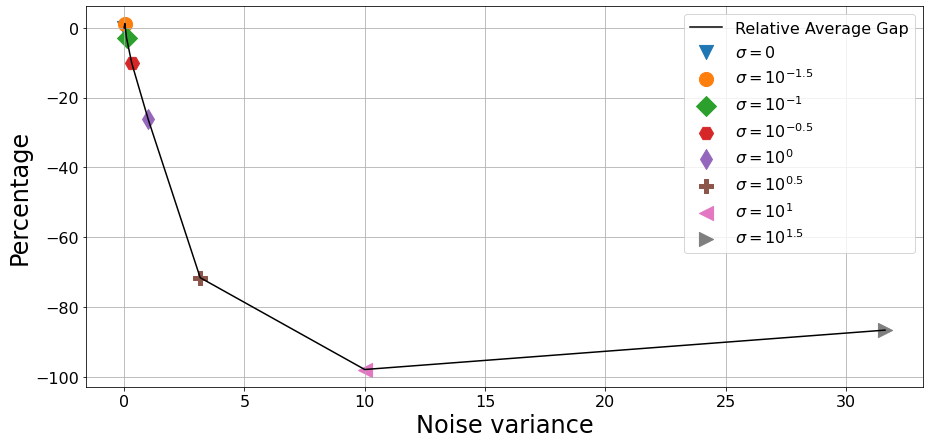

In [47]:
plot_CSI_Imperfect_Stats(variance, db_gap, 'Relative Average Gap', 'Noise variance','Percentage')

# Primary achievable rate degradation

In [81]:
def primary_rate(Grp, Gpp, Gsr, Gpr, Gss, Grs, Gsp, Gps, Alpha, Pr, Ps):
  """
      Parameters:
         Grp: 1D Array containing Alpha values.
         Gpp: 1D Array containing Gain between primary transmitter and primary receiver.
         Gsp: 1D Array containing Gain between secondary transmitter and primary receiver.
         Alpha: 1D Array containing Alpha values.
         Pr: 1D Array containing Power of relay.
         Ps: 1D Array containing Power of secondary network.
      
      Returns:
         primary debit.

  """
  Rp = C((Gpp*Pp)/(Grp*Pr**2+Gsp*Ps**2+2*(np.sqrt(Gsp*Grp)*Ps*Pr*Alpha)+1))
  return Rp


def mean_max_outage_PARD(N_P_Rate, Max_P_Rate):
    '''
    N_PRate : Primary rate based on bruteforce output (Alpha, Pr, Ps) where BF is computed using noisy channels 
    Max_P_Rate : Primary rate without secondary users interference
    '''
    res = 1-(N_P_Rate/Max_P_Rate) # Compute of Delta
    res = np.round(res,4)
    mean_res = np.nanmean(res) # Mean of Delta 
    max_res = np.max(res) # Max of Delta
    res = res[res>tau] # Outage
    with warnings.catch_warnings():
        warnings.filterwarnings('error')
        try:
            mean_outage = np.nanmean(res)
        except RuntimeWarning:
            mean_outage = 0
    
    return mean_res, max_res, mean_outage


def PARD_for_noisy_data(datas, labels):
    """
    Calculate primary rate for Noisy H Matrix
    """
    H_matrix, mean_pard, max_pard, mean_outage_pard = [], [], [], []

    for i in range(labels.shape[0]):
        H_matrix.append(datas)
    H_matrix = np.asarray(H_matrix, dtype="float32")
    
    for i,j in zip(H_matrix,labels) : 
        
        data , label = i[:,0:8], j[:,8:12]
        
        N_P_Rate = primary_rate(data[:,0], data[:,1], data[:,2], data[:,3], data[:,4], data[:,5], data[:,6], data[:,7], np.sqrt(label[:,1]), np.sqrt(label[:,2]), np.sqrt(label[:,3]))
        P_Rate_max = C(data[:,1]*Pp) # data[:,1] tend for G_PP

        temp_mean_pard, temp_max_pard, temp_mean_outage = mean_max_outage_PARD(N_P_Rate, P_Rate_max)
        mean_pard.append(temp_mean_pard)
        max_pard.append(temp_max_pard)
        mean_outage_pard.append(temp_mean_outage)
    # doesn't multiply outage by 100    
    return np.asarray(mean_pard, dtype="float32")*100, np.asarray(max_pard, dtype="float32")*100, np.asarray(mean_outage_pard, dtype="float32")

def plot_ARPD(var, mean_ARPD, maximum_ARPD):
    
    fig, ax = plt.subplots(1,figsize=(15,7))

    ax.plot(var, maximum_ARPD, c = 'blue',label=r"$Max$")
    ax.plot(var, mean_ARPD, c = 'red',label=r"$Mean$")

    ax.grid()

    xs = np.linspace(1, 10**1.5, 35)

    plt.hlines(y=25, xmin=0, xmax=len(xs), colors='black', linestyles='--', lw=2, label=r'$\tau = 25\%$')



    ax.scatter(variance[0], maximum_ARPD[0],label=r'$\sigma=0$',s=200,marker='v',linewidths=1)

    ax.scatter(variance[1], maximum_ARPD[1],label='$\sigma=10^{-1.5}$',s=200,marker='o',linewidths=1)

    ax.scatter(variance[2], maximum_ARPD[2],label='$\sigma=10^{-1}$',s=200,marker='D',linewidths=1)

    ax.scatter(variance[3], maximum_ARPD[3],label='$\sigma=10^{-0.5}$',s=200,marker='H',linewidths=1)

    ax.scatter(variance[4], maximum_ARPD[4],label='$\sigma=10^{0}$',s=200,marker='d',linewidths=1)

    ax.scatter(variance[5], maximum_ARPD[5],label='$\sigma=10^{0.5}$',s=200,marker='P',linewidths=1)

    ax.scatter(variance[6], maximum_ARPD[6],label='$\sigma=10^{1}$',s=200,marker='<',linewidths=1)

    ax.scatter(variance[7], maximum_ARPD[7],label='$\sigma=10^{1.5}$',s=200,marker='>',linewidths=1)


    ax.tick_params(axis='x', labelsize=16 )
    ax.tick_params(axis='y', labelsize=16)



    #ax.legend(loc='right', fontsize=16)

    plt.xlabel('Noise variance', fontsize=24)
    plt.ylabel('Primary network degradation (%)', fontsize=24)

    #fig.savefig('Datasetv2/Bruteforce/Dataset_for_BF/PDD.pdf', bbox_inches='tight')



Mean_ARPD, Max_ARPD, Outage_ARPD = PARD_for_noisy_data(dataset,dataset_test)





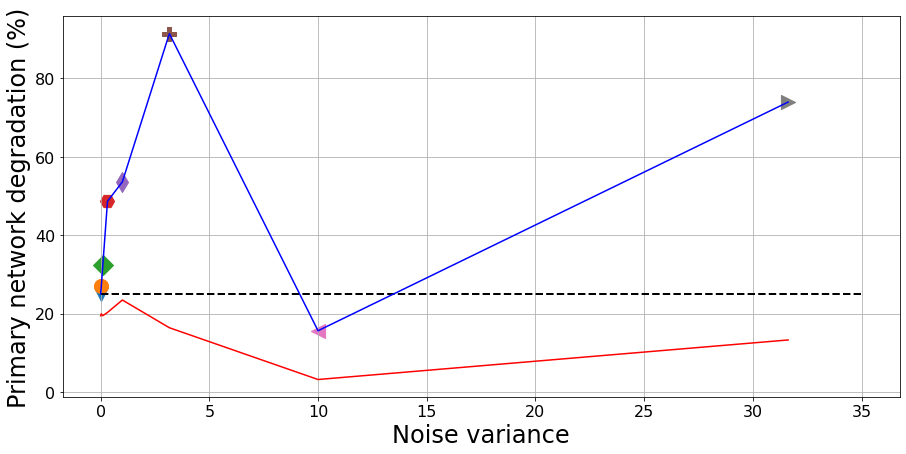

In [82]:
plot_ARPD(variance, Mean_ARDP, Max_ARDP)

# Outage   

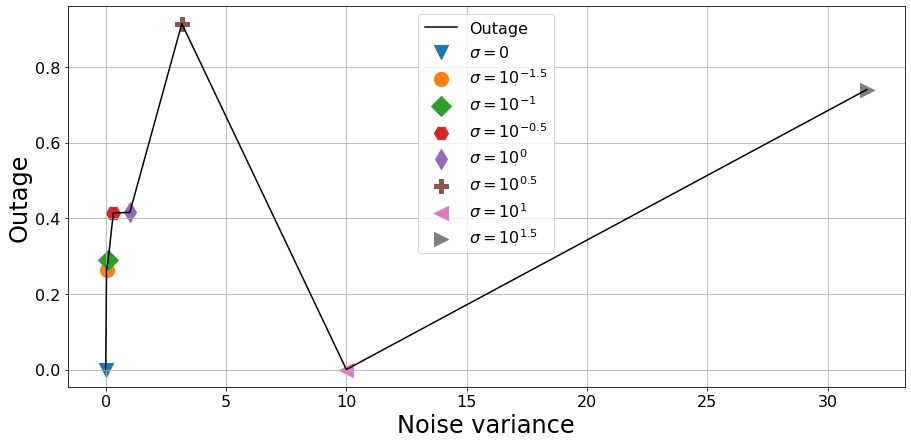

In [67]:

plot_CSI_Imperfect_Stats(variance, Outage_ARDP, 'Outage', 'Noise variance','Outage')


# Part 3 : Deep Neural Network 

## Secondary rate GAP

In [69]:
def DNN_predictions(NH_MATRIX):
    '''
    NH_MATRIX : Noisy H matrix 
    '''
    final_predictions = []
   
  
    # selection of the desired model
    # A :  "Weights_Model/CSI imperfection/DNN_GF.h5"
    # B : Weights_Model/CSI imperfection/Lambda/LD_10_0_5_ANNE.h5
    Model_Weight = "Weights_Model/CSI imperfection/Lambda/LD_10_0_5_ANNE.h5"
    # Load model
    model = tf.keras.models.load_model(Model_Weight, custom_objects={'DF_loss':loss_DF(Lambda,tau),'Primary_Achievable_Rate_Degradation':Primary_Achievable_Rate_Degradation,'Primary_ARDP':Primary_ARD_Percentage,'throughput':Achievable_Rate(tau),'V_Qos':QoS_Violation(tau), "custom_sigmoid":custom_sigmoid})
    
    for i in NH_MATRIX : 
        data = i[:,0:8]
        temp_predictions = model.predict(data)
        final_predictions.append(temp_predictions)
        
    return np.asarray(final_predictions, dtype="float32")

def opportunistic_rate_for_noisy_channels_DNN(datas, labels):
    '''
    dataset : H matrix without noise
    labels : predicted parameters (Alpha, Pr, Ps)
    #  Warning : rate is computed using y_hat not sqrt(y_hat) like opportunistic_rate_for_noisy_channels function

    '''
    final_rate = []
    H_matrix = []

    for i in range(labels.shape[0]):
        H_matrix.append(datas)
    H_matrix = np.asarray(H_matrix, dtype="float32")
    
    for i,j in zip(H_matrix, labels): 
        data , y_hat = i[:,0:8], j
        temp_rate = rate(data[:,0], data[:,1], data[:,2], data[:,3], data[:,4], data[:,5], data[:,6], data[:,7], y_hat[:,0], y_hat[:,1], y_hat[:,2])
        final_rate.append(temp_rate)
    return np.asarray(final_rate, dtype="float32")

def primary_degradation_for_noisy_data_DNN(datas, labels):
    final_pdd = []
    H_matrix = []

    for i in range(labels.shape[0]):
        H_matrix.append(datas)
    H_matrix = np.asarray(H_matrix, dtype="float32")
    
    for i,j in zip(H_matrix, labels): 
        data, y_hat = i[:,0:8], j
        temp_pdd = primary_rate(data[:,0], data[:,1], data[:,2], data[:,3], data[:,4], data[:,5], data[:,6], data[:,7], y_hat[:,0], y_hat[:,1], y_hat[:,2])
        final_pdd.append(temp_pdd)
        
    return np.asarray(final_pdd, dtype="float32")



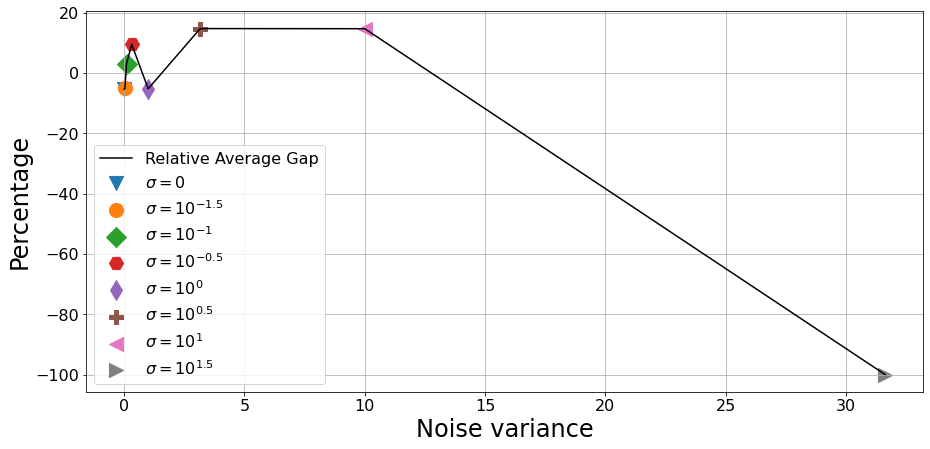

In [70]:

DNN_pred = DNN_predictions(NH_MATRIX)
db_DNN = opportunistic_rate_for_noisy_channels_DNN(dataset, DNN_pred)
db_benchmark = rate(dataset[:,0], dataset[:,1], dataset[:,2], dataset[:,3],dataset[:,4], dataset[:,5], dataset[:,6], dataset[:,7], np.sqrt(dataset[:,9]), np.sqrt(dataset[:,10]), np.sqrt(dataset[:,11]))



db_gap_DNN = np.array([relative_avreage_gap(db_DNN[0,:,8], db_benchmark[:,8]),\
                       relative_avreage_gap(db_DNN[1,:,8], db_benchmark[:,8]),\
                       relative_avreage_gap(db_DNN[2,:,8], db_benchmark[:,8]),\
                       relative_avreage_gap(db_DNN[3,:,8], db_benchmark[:,8]),\
                       relative_avreage_gap(db_DNN[4,:,8], db_benchmark[:,8]),\
                       relative_avreage_gap(db_DNN[5,:,8], db_benchmark[:,8]),\
                       relative_avreage_gap(db_DNN[6,:,8], db_benchmark[:,8]),\
                       relative_avreage_gap(db_DNN[7,:,8], db_benchmark[:,8])])



#ax.plot(variance, db_gap, c = 'blue',label='BF')

db_gap_DNN = db_gap_DNN*100

plot_CSI_Imperfect_Stats(variance, db_gap_DNN, 'Relative Average Gap', 'Noise variance','Percentage')

## Primary achievable rate degradation

In [77]:
def PARD_for_noisy_data_DNN(datas, labels):
    """
    Calculate primary rate for Noisy H Matrix
    """
    H_matrix, mean_pard, max_pard, mean_outage_pard = [], [], [], []

    for i in range(labels.shape[0]):
        H_matrix.append(datas)
    H_matrix = np.asarray(H_matrix, dtype="float32")
    
    for i,j in zip(H_matrix,labels) : 
        
        data , label = i[:,0:8], j # j not j[:,8:12]
        # label for primary_rate not sqrt label
        N_P_Rate = primary_rate(data[:,0], data[:,1], data[:,2], data[:,3], data[:,4], data[:,5], data[:,6], data[:,7], label[:,0], label[:,1], label[:,2])

        P_Rate_max = C(data[:,1]*Pp) # data[:,1] tend for G_PP

        temp_mean_pard, temp_max_pard, temp_mean_outage = mean_max_outage_PARD(N_P_Rate, P_Rate_max)
        mean_pard.append(temp_mean_pard)
        max_pard.append(temp_max_pard)
        mean_outage_pard.append(temp_mean_outage)
    # doesn't multiply outage by 100    
    return np.asarray(mean_pard, dtype="float32")*100, np.asarray(max_pard, dtype="float32")*100, np.asarray(mean_outage_pard, dtype="float32")




Mean_ARDP_DNN, Max_ARDP_DNN, Outage_ARDP_DNN = PARD_for_noisy_data(dataset,dataset_test)



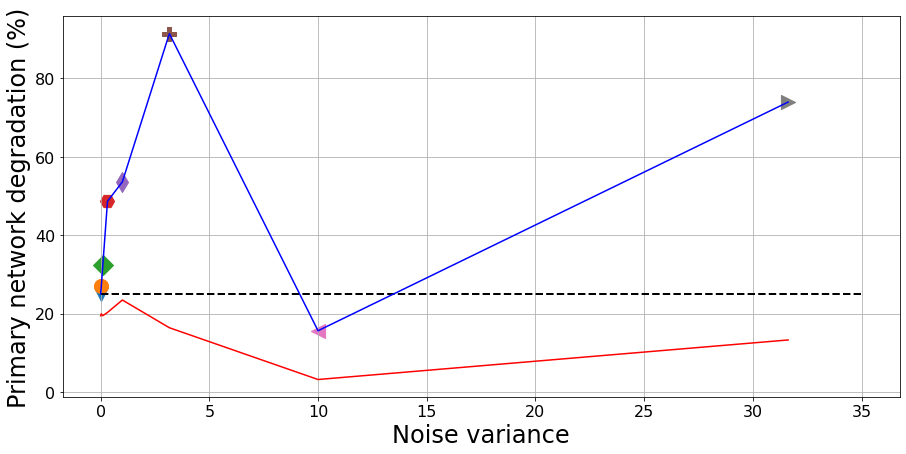

In [78]:
plot_ARPD(variance, Mean_ARDP_DNN, Max_ARDP_DNN)

# Outage

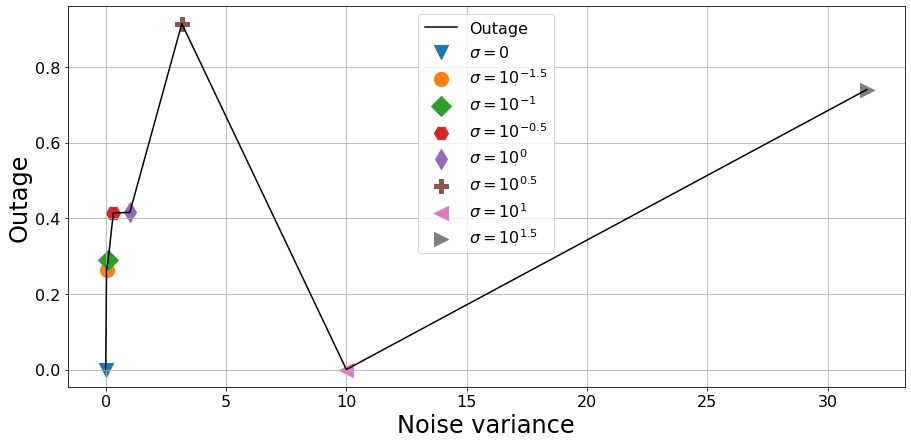

In [73]:

plot_CSI_Imperfect_Stats(variance, Outage_ARDP, 'Outage', 'Noise variance','Outage')

